In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Extract Data

In [3]:
import zipfile
train_zip='../input/dogs-vs-cats-redux-kernels-edition/train.zip'
zip_ref=zipfile.ZipFile(train_zip,'r').extractall('./')

test_zip = '../input/dogs-vs-cats-redux-kernels-edition/test.zip'
zip_ref=zipfile.ZipFile(test_zip,'r').extractall('./')


In [4]:
import os
train_filenames = os.listdir('./train')
test_filenames = os.listdir('./test')

In [5]:
# Create DataFrame for ImageDataGenerator
train = pd.DataFrame(columns=['path', 'label'])
train['path'] = train_filenames
train['label'] = train['path'].str[0:3]

In [6]:
train.head()

,path,label
0,cat.2606.jpg,cat
1,cat.335.jpg,cat
2,cat.8319.jpg,cat
3,dog.6968.jpg,dog
4,cat.7474.jpg,cat


<AxesSubplot:>

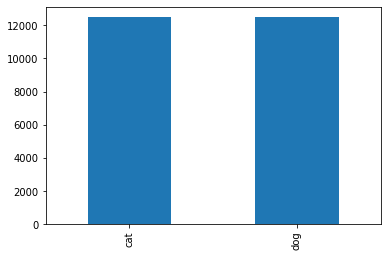

In [7]:
train.label.value_counts().plot.bar() # Balanced Data

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2)

In [9]:
width, height = 150, 150
trainDatagen = train_datagen.flow_from_dataframe(train, directory = './train', x_col='path', y_col='label', classes=['cat', 'dog' ],
                                           target_size=(width,height), class_mode = 'categorical', batch_size = 16,
                                           subset='training')

valDatagen = train_datagen.flow_from_dataframe(train, directory = './train', x_col='path', y_col='label', classes=['cat','dog'],
                                           target_size=(width,height), class_mode = 'categorical', batch_size = 16,
                                           subset='validation')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [10]:
x, y = trainDatagen.next()
x.shape, y.shape

((16, 150, 150, 3), (16, 2))

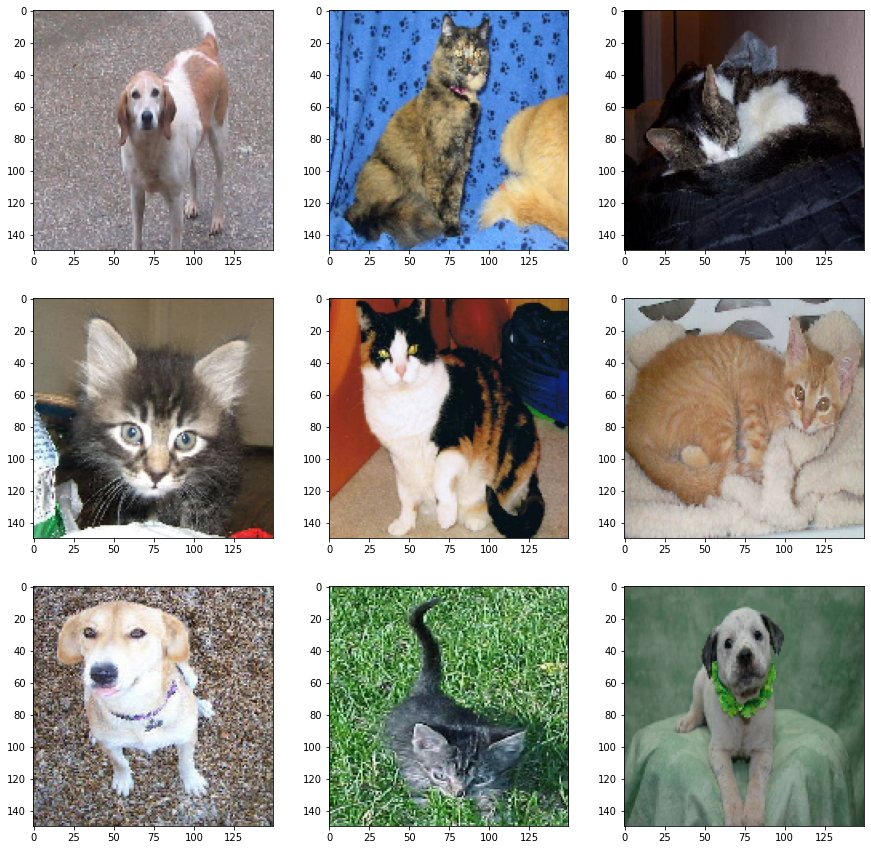

In [11]:
plt.figure(figsize=(15,15))
for i in range(9):
    img, label = trainDatagen.next()
    plt.subplot(331+i)
    plt.imshow(img[0])
plt.show()

## Test Data

In [12]:
test = pd.DataFrame(columns=['path'])
test['path'] = test_filenames
test.head()

,path
0,5062.jpg
1,5488.jpg
2,2230.jpg
3,2505.jpg
4,8628.jpg


In [13]:
test_datagen = ImageDataGenerator(rescale=1/255.0)
width, height = 150, 150
testDatagen = test_datagen.flow_from_dataframe(test, directory = './test', x_col='path', class_mode= None,
                                           target_size=(width,height), batch_size = 16, shuffle=False)

Found 12500 validated image filenames.


## Training and Prediction

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
 
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
    
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
 
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(2,activation='softmax'))

model.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(learning_rate=1e-4),metrics=['acc'])
 
model.summary()

2022-08-30 09:49:23.651064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

2022-08-30 09:49:23.803312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 09:49:23.807145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 09:49:23.812203: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 09:49:23.812667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [15]:
history = model.fit(trainDatagen, steps_per_epoch = len(trainDatagen), epochs=10, validation_data = valDatagen, validation_steps=len(valDatagen), shuffle=True)

2022-08-30 09:49:28.014062: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-30 09:49:30.032350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 93s 67ms/step - loss: 0.7385 - acc: 0.6635 - val_loss: 0.6098 - val_acc: 0.7166
Epoch 2/10
1250/1250 [==============================] - 80s 64ms/step - loss: 0.5624 - acc: 0.7401 - val_loss: 0.5622 - val_acc: 0.7570
Epoch 3/10
1250/1250 [==============================] - 80s 64ms/step - loss: 0.4589 - acc: 0.7909 - val_loss: 0.4499 - val_acc: 0.7958
Epoch 4/10
1250/1250 [==============================] - 78s 63ms/step - loss: 0.3965 - acc: 0.8213 - val_loss: 0.4980 - val_acc: 0.7838
Epoch 5/10
1250/1250 [==============================] - 79s 63ms/step - loss: 0.3504 - acc: 0.8438 - val_loss: 0.3869 - val_acc: 0.8370
Epoch 6/10
1250/1250 [==============================] - 78s 62ms/step - loss: 0.3039 - acc: 0.8676 - val_loss: 0.4762 - val_acc: 0.8066
Epoch 7/10
1250/1250 [==============================] - 78s 63ms/step - loss: 0.2643 - acc: 0.8892 - val_loss: 0.3687 - val_acc: 0.8454
Epoch 8/10
1250/1250 [==============================] - 78s

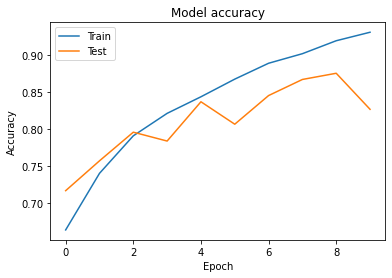

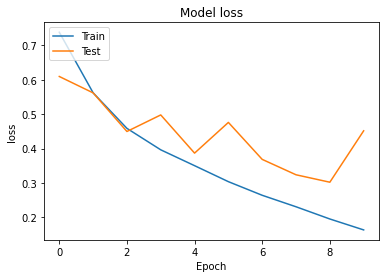

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

In [17]:
predictions = model.predict(testDatagen, batch_size=32, verbose =1)
predictions

782/782 [==============================] - 36s 46ms/step


array([[3.0416796e-02, 9.6958321e-01],
       [7.9504460e-01, 2.0495540e-01],
       [2.8725544e-02, 9.7127444e-01],
       ...,
       [5.5941463e-01, 4.4058540e-01],
       [9.9908578e-01, 9.1418112e-04],
       [9.8260307e-01, 1.7396975e-02]], dtype=float32)

In [18]:
submission = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission['label'] = predictions[:,0]
submission.to_csv('submission.csv', index=False)
submission.head()

,id,label
0,1,0.030417
1,2,0.795045
2,3,0.028726
3,4,0.000758
4,5,0.131713
